# Demo Retrieving Wav Files to Tympan

In [1]:
import tympan_serial as tymp                # Module for managing Tympan serial ports and file transfer
#from time import sleep

### Open Serial Port

In [2]:
tymp_port = tymp.TympanSerial()
err = None
err = tymp_port.connect()

Opened:  COM5


### Print Help Menu

In [3]:
tymp_port.send_char("h")
reply = tymp_port.read_all()
print (reply)

SerialManager Help: Available Commands:
 General: No Prefix
   h    : Print this help
   w/W/e/E: INPUT  : Switch to the PCB Mics / Pink Jack - Mic Bias / Pink Jack Line in / Digital mics
   k/K  : CHIRP  : Incr/decrease loudness of chirp (cur = 0.0 dBFS)
   d/D  : CHIRP  : Incr/decrease duration of chirp (cur = 5.0 sec)
   n    : CHIRP  : Start the chirp
   1-3  : SDPlay : Play files 1-3 from SD Card
   q    : SDPlay : Stop any currently plying SD files
   c    : AutoWrite : Start chirp and SD recording together
   4-6  : AutoWrite : Start files 1-3 from SD Card and SD recording together
   g/G  : OUTPUT : Incr/decrease DAC loudness (cur = -20.0 dB)
   r/s  : SDWrite: Manually Start/Stop recording
---------------------------------------------------
   L    : List of the files on SD card
   f    : Open the file from SD (will prompt you for filename)
   b    : Get the size of the file in bytes
   t    : Transfer the whole file from SD to Serial
 AudioSDWriter: Prefix = _Ax
   r,s,d: SD 

### Set Audio Input

In [186]:
# Set audio input
tymp_port.send_char('E')                             # Digital (PDM) mics
#tymp_port.send_char('W')                            # Pink mic jack with bias voltage
#tymp_port.send_char('e')                            # Pink mic jack with no bias (generally not used with typical mics)
#tymp_port.send_char('w')                            # PCB mics on Tympan board

reply = tymp_port.read_all()
print (reply)

d/stop/deleteAll

Received: Switch input to digital PDM mics
AudioControlAIC3206: Received Error During goToPage(): Error = 2
AudioControlAIC3206: Received Error During writeRegister(): Error = 2
AudioControlAIC3206: Received Error During writeRegister(): Error = 2
AudioControlAIC3206: Received Error During writeRegister(): Error = 2
AudioControlAIC3206: Received Error During writeRegister(): Error = 2
AudioControlAIC3206: Received Error During goToPage(): Error = 2
AudioControlAIC3206: Received Error During goToPage(): Error = 2
AudioControlAIC3206: Received Error During goToPage(): Error = 2
AudioControlAIC3206: Received Error During goToPage(): Error = 2
AudioControlAIC3206: Received Error During goToPage(): Error = 2
AudioControlAIC3206: Received Error During goToPage(): Error = 2
SerialManagerBase: sending: STATE=BTN:configPCB:0
SerialManagerBase: sending: STATE=BTN:configMIC:0
SerialManagerBase: sending: STATE=BTN:configLINE:0
SerialManagerBase: sending: STATE=BTN:configPDM:0
Ser

### Play a wav file from SD card

In [5]:
tymp_port.send_char('1')

reply = tymp_port.read_line(eof_str="finished.")
print(reply)

TATE=BTN:configPDM:1
SerialManagerBase: sending: TEXT=BTN:inpGain:0.0
serviceAudioSdStartStop: Starting SD 1 playback...
serviceChirpStartStop: Chirp or SD has finished.



### Play a wav file from SD and make a recording

In [ ]:
tymp_port.send_char('4')
reply = tymp_port.read_line(eof_str="finished.", timeout_s=5)
print(reply)

# Clear buffer
tymp_port.read_all()

### List files on Tympan SD card

In [265]:
def processLineIntoFilenames(line):
    # Assumes we are given one line that contains comma-seperated filenames.  
    # The line of text might contain preamble text, which will end with a colon.
    # So, find the last colon and only keep the text after the last colon.
    line = line.split(':')  #split into sections
    line = line[-1]  #get everything after the last split
    
    #Now, split the text at the colons
    names = line.split(',')
    all_fnames = []
    for name in names:
        name = name.strip()
        if len(name) > 0:
            all_fnames.append(name.strip())  #remove whitespace before and after and save
        #
    #
    return all_fnames

# let's ask for a list of files on the Tympan's SD card
tymp_port.get_rx_buffer()                                      # Clear buffer
tymp_port.send_char("L")
reply = tymp_port.read_line(timeout_s=2)

# let's break up the full text reply into the filenames
fnames = processLineIntoFilenames(reply)                   #parse out the filenames
print("RESULT: Files on Tympan SD:")
for f in fnames:
    print("\t", f)                    #print the line to the screen here in Python

. RESULT: Files on Tympan SD:
	 dummy.txt
	 AUDIO001.WAV
	 AUDIO002.WAV
	 AUDIO003.WAV
	 AUDIO004.WAV
	 AUDIO005.WAV
	 AUDIO006.WAV
	 AUDIO007.WAV
	 AUDIO008.WAV
	 AUDIO009.WAV
	 AUDIO010.WAV
	 AUDIO011.WAV
	 AUDIO012.WAV
	 AUDIO013.WAV
	 AUDIO014.WAV
	 AUDIO015.WAV
	 AUDIO016.WAV
	 AUDIO017.WAV
	 AUDIO018.WAV
	 AUDIO019.WAV


### Download file to the PC

In [266]:
err = None

# Specify a name using file_to_download or leave blank to download the last file
file_to_download = None              #'PLAY1.WAV'

# Check that there are files to download
if len(fnames) <1:
    err = "ERR: No file specified"
    print(err)

# If no file specified, use the last file listed
if (not err and not file_to_download):
    file_to_download = fnames[-1] #load the last (ie, the most recent?)

# Prepare to open a the file on the Tympan
reply = []
if not(err):
    print("ACTION: Asking for file:",file_to_download)
    tymp_port.send_char('f')    
    reply = tymp_port.read_line(timeout_s=3)
    print("REPLY:",reply.strip())                            

    # Check for errors
    if ("ERROR" in reply):
        err = reply
        
# Send the filename that we want
reply = []
if not(err):
    tymp_port.send_string(file_to_download)     
    reply = tymp_port.read_line(eof_str='successfully opened', timeout_s=3)
    print("REPLY:",reply.strip())              
    
    # Check for errors
    if ("ERROR" in reply):
        err = reply
        print("Err: ", reply)      

ACTION: Asking for file: AUDIO019.WAV
. REPLY: SerialMonitor: Opening file: Send filename (ending with newline character) within 10 seconds
REPLY: SerialMonitor: AUDIO019.WAV successfully opened


In [267]:
# Get the file size in bytes
reply = []
n_bytes = []

if not(err):
    # Clear the buffer
    tymp_port.read_all() 

    tymp_port.send_char('b')                   
    reply = tymp_port.read_line(timeout_s=3)
       
    # Check for error
    try:
        n_bytes = int(reply)                                      
        if (n_bytes>0):
            print("RESULT: File size: ", n_bytes, " bytes")                           
    
    except Exception as e:
        err = e
        print("Err: Failed to read file size.", err)

if not(err):
    # Clear the buffer
    tymp_port.read_all() 

    tymp_port.send_char('b')                   
    reply = tymp_port.read_line(timeout_s=3)
       
    # Check for error
    try:
        n_bytes = int(reply)                                      
        if (n_bytes>0):
            print("RESULT: File size (B) =", n_bytes)                           
    
    except Exception as e:
        err = e
        print("Err: Bad file size.", err)

. RESULT: File size:  384044  bytes
. RESULT: File size (B) = 384044


In [268]:
# Transfer the file itself
block_size = 8192
end_seq_bytes = 2

if not(err):
    # Clear the buffer
    tymp_port.get_rx_buffer()
    buf = bytearray()
    transfer_done_flag = False

    while( (len(buf)<n_bytes ) and not(transfer_done_flag) ):
        #Request (1) block
        tymp_port.send_char('t')
        print(".", end='')
        tmp_buf = tymp_port.get_rx_buffer(timeout_s=.5, num_bytes=block_size+2)
        
        # Append block (but leave off (2) bytes for the \r and \n)
        if( len(tmp_buf)>0 ):
            buf +=tmp_buf[0:-2]
            
        else:
            transfer_done_flag = True

    #Check for error
    try:
        if(n_bytes==len(buf)):
            print ("Successfully downloaded Bytes: ", n_bytes)
            wav_bin = buf
        else:
            err = "Err: Did not download full file size"
            print(err, len(buf), 'of', n_bytes)
    except Exception as e:
        err = e
        print(err)

.. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .Successfully downloaded Bytes:  384044


### Verify WAV file

In [270]:
# Verify wav file header starts with ASCII 'RIFF' (0x52494646) and 'fmt '
if (wav_bin[0:4] == bytearray(b'RIFF')) and \
    (wav_bin[12:16] == bytearray(b'fmt ')) and \
    (wav_bin[36:40]==bytearray(b'data')):
    
    print("WAV File Verifed")      #Could you better error checking of header vs data

# Header not valid, or could be a header file of unexpected length. 
#    Should actually search for the keyword 'data' then skip 4 bytes
else: 
    err = 'ERR: Wave file header not valid, or header unexpected length'
    print(err)

WAV File Verifed


### Split WAV file into Header and Data

In [271]:
import struct
import numpy as np

# Parse header properties
wav_props = {}
wav_props['FileSize'] = struct.unpack('<L', wav_bin[4:8])[0]
wav_props['AudioFormat'] = struct.unpack('<H', wav_bin[20:22])[0]
wav_props["num_channels"] = struct.unpack('<H', wav_bin[22:24])[0]
wav_props['SampleRate'] = struct.unpack('<L', wav_bin[24:28])[0]
wav_props['BitsPerSample'] = struct.unpack('<H', wav_bin[34:36])[0]
wav_props['DataSize'] = struct.unpack('<L', wav_bin[40:44])[0]

print(wav_props)

# Verify FileSize = Total size - 8 bytes (as per WAV standard)
if ( (wav_props['FileSize']+8) ==n_bytes):
    # Parse data 
    bufI16 = np.frombuffer(wav_bin[44:], dtype=np.int16)
    wavI16 = bufI16.reshape(-1,wav_props["num_channels"])
else:
    err = "Err: Invalid file size"
    print(err)


{'FileSize': 384036, 'AudioFormat': 1, 'num_channels': 4, 'SampleRate': 96000, 'BitsPerSample': 16, 'DataSize': 384000}


### Plot Data

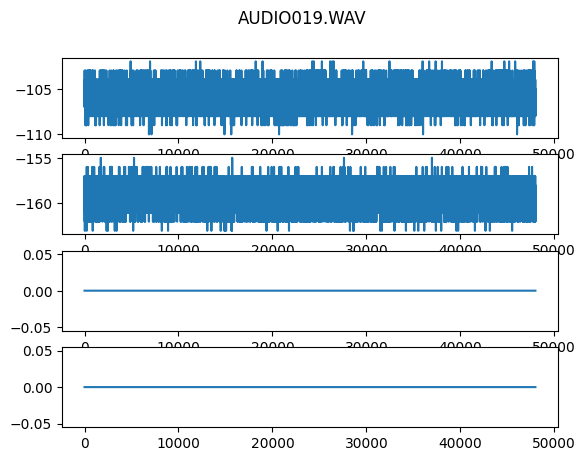

In [273]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(wav_props['num_channels'])
fig.suptitle(file_to_download)
for chanIdx in range(wav_props['num_channels']):
    axs[chanIdx].plot(wavI16[:,chanIdx])

### Write file to local disk

In [274]:
import tkinter as tk
from tkinter import filedialog
from pathlib import Path

root = tk.Tk()
root.withdraw()

if not(err):
    if not ("file_path" in locals() ):
        file_path = Path(filedialog.askdirectory())

    with open(file_path/file_to_download, "wb") as file:
        file.write(wav_bin)
        print("Wav file written:", file_path/file_to_download)


Wav file written: C:\Users\eyuan\Downloads\AUDIO019.WAV


### Read WAV file back into Python

In [275]:
import wave
import numpy as np

with wave.open(str(file_path/file_to_download), 'rb') as f:
    print("Reading WAV file back in: ", file_to_download)
    print("Sample Rate (hz): ", f.getframerate())
    print("Channels: ", f.getnchannels())
    wav_rate_hz = f.getframerate()
    wav_num_channels = f.getnchannels()

    # Read the whole file into a buffer. If you are dealing with a large file
    # then you should read it in blocks and process them separately.
    buffer = f.readframes(f.getnframes())
    # Convert the buffer to a numpy array by checking the size of the sample
    # width in bytes. The output will be a 1D array with interleaved channels.
    interleaved = np.frombuffer(buffer, dtype=f'int{f.getsampwidth()*8}')
    # Reshape it into a 2D array separating the channels in columns.
    wav_data = np.reshape(interleaved, (-1, f.getnchannels()))

Reading WAV file back in:  AUDIO019.WAV
Sample Rate (hz):  96000
Channels:  4


### Plot Local Wav File

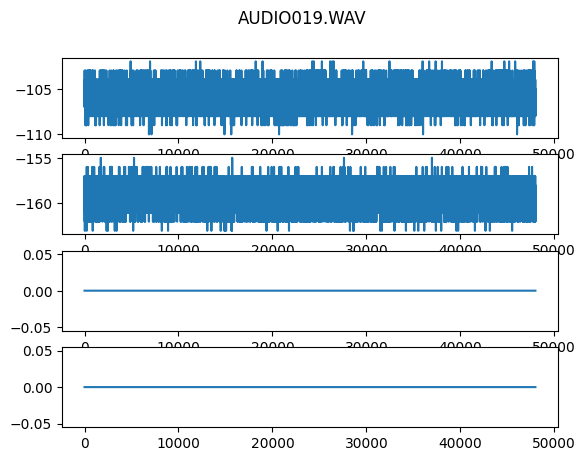

In [276]:
fig, axs = plt.subplots(wav_num_channels)
fig.suptitle(file_to_download)
for chanIdx in range(wav_num_channels):
    axs[chanIdx].plot(wav_data[:,chanIdx])

### Play audio

In [279]:
import pygame
pygame.mixer.init()
pygame.mixer.music.load(file_path/file_to_download)
pygame.mixer.music.play()
while pygame.mixer.music.get_busy():
    pass

In [283]:
# Close Serial Port
tymp_port.stop_rx_thread()
tymp_port.port_h.close()